![tata](http://cots.perso.enseeiht.fr/figures/inp-enseeiht.png)

# Tir simple indirect : une introduction

Le but est de résoudre par du tir simple indirect, deux problèmes simples de contrôle optimal dont le contrôle maximisant est lisse. 
Le premier problème possède des conditions aux limites simples tandis que le second aura des conditions de transversalités.

**Packages.** 

In [2]:
using DifferentialEquations, Plots, NLsolve, ForwardDiff

## Exercice 1

On considère le problème de contrôle optimal suivant :

$$ 
    \left\{ 
    \begin{array}{l}
        \displaystyle \min\, \frac{1}{2} \int_0^{1} u^2(t) \, \mathrm{d}t \\[1.0em]
        \dot{x}(t) = -x(t) + \alpha x^2(t) + u(t), \quad  u(t) \in \mathrm{R}, \quad t \in [0, 1] \text{ p.p.},    \\[1.0em]
        x(0) = -1, \quad x(1) = 0.
    \end{array}
    \right. 
$$

Pour $\alpha \in \{0, 1.5\}$, faire :

1. Afficher le flot du système hamiltonien associé et afficher 5 fronts aux temps $0$, $0.25$, $0.5$, $0.75$ et $1$. On pourra utiliser le TP précédent.

2. Coder la fonction de tir 

$$
S(p_0) = \pi(z(t_f, x_0, p_0)) - x_f,
$$

où $t_f = 1$, $x_0=-1$, $x_f = 0$. On pourra se référer au polycopié de cours, cf. chapitre 5, pour les notations et la définition de la fonction de tir.

3. Afficher la fonction de tir pour $p_0 \in [0, 1]$.

4. Résoudre l'équation $S(p_0) = 0$ et tracer l'extrémale dans le plan de phase, cf. question 1.

Remarques. 

* Voici quelques appels de fonctions pouvant aider au calcul du flot d'un système hamiltonien~:

```julia
    # Hamiltonian system
    function hv(x, p)
        r = [0; 0] 
        return r
    end

    # Makes flow from a Hamiltonian system
    f = Flow(hv)
```

* Voici quelques appels de fonctions pouvant aider à la résolution des équations de tir~:

```julia
    # jacobienne de la fonction de tir
    jshoot(p0) = ForwardDiff.jacobian(shoot, p0)

    # résolution de shoot(p0) = 0. L'itéré initial est appelé p0_guess
    sol = nlsolve(shoot, jshoot, p0_guess; xtol=1e-8, method=:trust_region, show_trace=true);
```

In [3]:
function Flow(hv)

    function rhs!(dz, z, dummy, t)
        n = size(z, 1)÷2
        dz[:] = hv(z[1:n], z[n+1:2*n])
    end
    
    function f(tspan, x0, p0; abstol=1e-12, reltol=1e-12, saveat=[])
        z0 = [ x0 ; p0 ]
        ode = ODEProblem(rhs!, z0, tspan)
        sol = solve(ode, Tsit5(), abstol=abstol, reltol=reltol, saveat=saveat)
        return sol
    end
    
    function f(t0, x0, p0, tf; abstol=1e-12, reltol=1e-12, saveat=[])
        sol = f((t0, tf), x0, p0, abstol=abstol, reltol=reltol, saveat=saveat)
        n = size(x0, 1)
        return sol[1:n, end], sol[n+1:2*n, end]
    end
    
    return f

end

Flow (generic function with 1 method)

In [5]:
t0=0.;tf=1.;x0=-1.;xf=0.
tspan = (t0,tf)

function hv(x,p,t)
    n = size(x,1)
    zpoint=zeros(2*n)
    zpoint[1:n] = -x + p
    zpoint[n+1:2*n] = p
    return zpoint
end

f=Flow(hv)

function shoot(p0)
    x,p = f(t0,x0,p0,tf)
    return x.-xf
end

#jshoot(p0) = ForwardDiff.jacobian(shoot, p0)

#sol = nlsolve(shoot, [0.]; xtol=1e-8, method=:trust_region, show_trace=true);




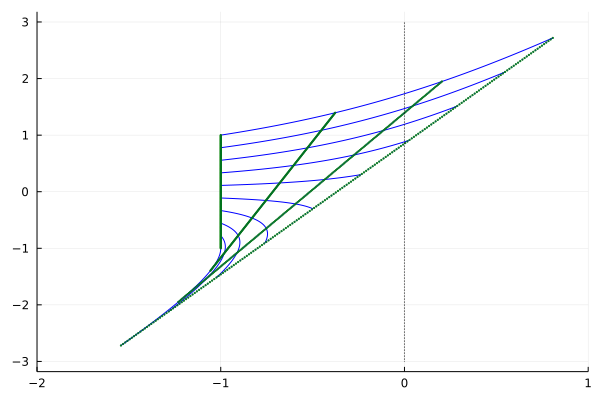

In [27]:
function fun1(z,p,t)
    zpoint = similar(z)
    zpoint[1] = -z[1] + z[2]
    zpoint[2] = z[2]
    return zpoint
end

function plot_traj(plt,f,Z0,tf; par=[])
    
    nbpoints = size(Z0,2)
    tspan = (0. , tf)
    for i in 1:nbpoints                      
        prob = ODEProblem(f,Z0[:,i],tspan,par)          # défini le problème en Julia
        sol = solve(prob)
        plot!(plt, sol, vars = (1,2),legend = false, color = :blue) # lw = linewidth
     end
    return nothing
end   

function plot_flow(plt,f,Z0,tf; par=[])
   
    nbpoints = size(Z0,2)
    tspan = (0. , tf)
    T = range(0.,tf,length=4)
    for i in 1:nbpoints  
        prob = ODEProblem(f,Z0[:,i],tspan,par)          # défini le problème en Julia
        sol = solve(prob)
        for t in T
            plot!(plt, [sol(t)[1]],[sol(t)[2]], seriestype = :scatter,legend = false, color = :blue , markerstrokecolor = :green , markersize = 1) # lw = linewidth # x,p
        end
    end
    return nothing
end;
seg = range(-1.,1.,length=10)
Z0 = transpose([-ones(size(seg)) seg])
plt1 = plot()
plot_traj(plt1,fun1,Z0,tf)

seg = range(-1.,1.,length=200)
Z0 = transpose([-ones(size(seg)) seg])
plot_flow(plt1,fun1,Z0,tf)
plot!(plt1, xlims = (-2.,1))
plot!(plt1,[0.,0.],[-3.,3], linestyle = :dot, color = :black)

## Exercice 2

On considère le problème de contrôle optimal suivant :

$$ 
    \left\{ 
    \begin{array}{l}
        \displaystyle \min\, \frac{1}{2} \int_0^{t_f} ||u(t)||^2 \, \mathrm{d}t \\[1.0em]
        \dot{x}(t) = (0, \alpha) + u(t), \quad  u(t) \in \mathrm{R}^2, \quad t \in [0, t_f] \text{ p.p.},    \\[1.0em]
        x(0) = a, \quad x(t_f) \in b + \mathrm{R} v,
    \end{array}
    \right. 
$$

avec $a = (0,0)$, $b = (1,0)$, $v = (0, 1)$ et $t_f = 1$.

Pour différente valeur de $\alpha$, faire :

1. Résoudre le problème de contrôle optimal par du tir simple.

2. Tracer la trajectoire solution dans le plan $(x_1, x_2)$.

3. Tracer pour la solution, attaché au point $x(t_f)$, les vecteurs $\dot{x}(t_f)$ et $p(t_f)$. Commentaire ?

In [17]:
t0=0.;
tf=1.;
x0=[0;0];
tspan = (t0,tf);

#p0=-1;
alpha=1;

function hv1(x,p)
    r = [p[1] ; alpha + p[2] ; 0 ; 0]
    return r
end

f=Flow(hv1)

function shoot(p0)
    x,p = f(t0,x0,p0,tf)
    return [x[1]-1;p[2]]
end

p0_guess = [0.1; 0.1]

jshoot(p0) = ForwardDiff.jacobian(shoot, p0)

sol = nlsolve(shoot, jshoot, p0_guess; xtol=1e-8, method=:trust_region, show_trace=true);




Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-01              NaN
     1     7.594436e-01     1.414214e-01
     2     4.783308e-01     2.828427e-01
     3     0.000000e+00     4.812744e-01


In [18]:
p0_sol = sol.zero     #le zero de la fonction (S(p0) = 0)

2-element Vector{Float64}:
 1.0000000000000002
 0.0

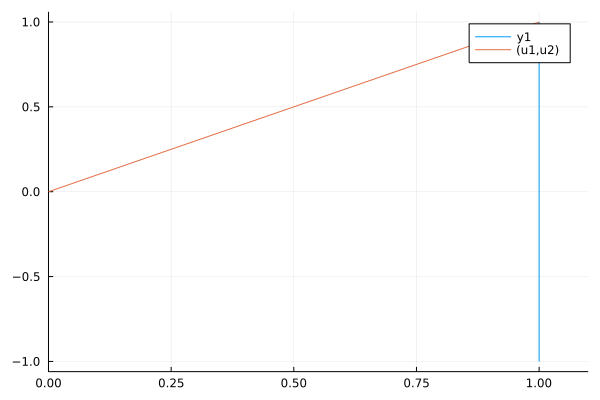

In [22]:
ode_sol = f((t0,tf), x0, p0_sol);
plt = plot([1,1],[-1,1])         #cible
plot(plt, ode_sol, vars=(1,2))   #trajectoire optimale

zf = ode_sol(:, end)
xf = zf[1:2]
pf = zf[3:4]
quiver!(plt, [xf[1]], [xf[2]], )    #vecteur adjoint    (A finir)